In [203]:
import pandas as pd
import plotly.express as px
from pymongo import MongoClient
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from utils import (
    extrapolated_multiitemp_lambdahat
)
import plotly.io as pio
from dln import (
    true_dln_learning_coefficient
)
import json
import os

In [627]:
def extract_data(subdir):
    with open(os.path.join(subdir, 'config.json'), 'r') as f:
        config = json.load(f)

    with open(os.path.join(subdir, 'info.json'), 'r') as f:
        info = json.load(f)
    doc = {"config": config, "info": info}

    data = {
        "epsilon": config.get('sgld_config', {}).get('epsilon'),
        "num_steps": config.get('sgld_config', {}).get('num_steps'),
        "input_dim": config.get('input_dim'),
        "layer_widths": config.get('layer_widths'),
        "num_training_data": config.get('num_training_data'),
        "itemp": config.get('itemp'),
        "lambdahat": info.get('lambdahat'),
        "true_lambda": info.get('true_lambda'),
        "true_rank": info.get('true_rank'),
        "loss_trace": info.get('loss_trace'),
        "init_loss": info.get('init_loss'),
        "true_multiplicity": info.get('true_multiplicity'),
        "lambdahat_trained": info.get('trained_param_info', {}).get('lambdahat'),
        "model_dim": info.get('model_dim'),
        "functional_rank": info.get('functional_rank_info', {}).get('functional_rank'),
        "hessian_trace_estimate": info.get('hessian_trace_estimate'),
        "svdvals": info.get('functional_rank_info', {}).get('singular_values'), 
        "mala_acceptance_probs": info.get("mala_acceptance_probs")
    }
    return data, doc


# directory_path = './spartan_outputs/202401191706'
# directory_path = './spartan_outputs/random_batch500_width500-1000_layer2-20_trainTrue_202401200314'
directory_path = "./spartan_outputs/rand_rank_batch500_width500-1000_layer2-20_trainTrue_202401200311"
# directory_path = "./spartan_outputs/zero_batch500_width500-1000_layer2-20_trainTrue_202401201530"
# directory_path = "./spartan_outputs/random_batch500_width500-3000_layer2-20_trainFalse_202401210232"
# directory_path = "./spartan_outputs/rand_rank_batch500_width500-3000_layer2-20_trainFalse_202401210232"
# directory_path = "./spartan_outputs/zero_batch500_width500-3000_layer2-20_trainFalse_202401210233"

# directory_path = "./spartan_outputs/zero_batch500_width500-3000_layer2-20_trainFalse_202401211705"
# directory_path = "./spartan_outputs/random_batch500_width500-3000_layer2-20_trainFalse_202401211705"
# directory_path = "./spartan_outputs/rand_rank_batch500_width500-3000_layer2-20_trainFalse_202401211705"

EXPT_NAME = os.path.split(directory_path)[1]
all_data = []

for subdir in os.listdir(directory_path):
    full_subdir_path = os.path.join(directory_path, subdir)
    if subdir == "_sources" or not os.path.isdir(full_subdir_path):
        continue
    if set(["info.json", "config.json"]).issubset(set(os.listdir(full_subdir_path))):
        try: 
            data, doc = extract_data(full_subdir_path)
            data["_id"] = int(subdir)
            all_data.append(data)
            sample_doc = doc
        except:
            print("ERROR: ", full_subdir_path)

# Convert to pandas DataFrame
df_data = pd.DataFrame(all_data)
print(df_data.shape)


ERROR:  ./spartan_outputs/rand_rank_batch500_width500-1000_layer2-20_trainTrue_202401200311/28
(97, 19)


# Querying data from DB and parsing

In [348]:

# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['dln_lambdahat']
# db = client['dln_lambdahat_dev']
collection = db['runs']

# Query data
# EXPT_NAME = "dev"
# EXPT_NAME = "dev_hessian2"

# EXPT_NAME = "random_sv_20231213"
# EXPT_NAME = "batch500_width10-100_layer2-20_sv_202312130129"
# EXPT_NAME = "batch500_width10-100_layer2-10_sv_202312131012"
# EXPT_NAME = "batch500_width10-100_layer2-10_sv_202312131121"
# EXPT_NAME = "batch500_width2-10_layer5_sv_202312131342" # fix layer=5, vary widths 2-20
# EXPT_NAME = "batch500_width2-10_layer5_sv_202312131424" # fix widths=5, vary layer=2-20
# EXPT_NAME = "zerotruth_batch500_width10-100_layer2-20_sv_202312132339"

# EXPT_NAME = "randsv_batch500_width10-50_layer2-15_sv_202312141156"
# EXPT_NAME = "randsv_batch500_width10-50_layer2-15_sv_202312141203"

# EXPT_NAME = "randsv_batch500_width10-50_layer2-15_withtraining_202312150141"
# EXPT_NAME = "zero_batch500_width10-50_layer2-15_withtraining_202312150205"
# EXPT_NAME = "randrank_batch500_width10-50_layer2-15_withtraining_202401162253"
EXPT_NAME = "randrank_batch500_width10-50_layer2-15_withtraining_prank0.8_202401170119"
# EXPT_NAME = "randrank_batch500_width10-50_layer2-15_withtraining_prank0.2_202401170120"

# EXPT_NAME = "randsv_batch500_width2-5_layer2-5_notraining_202312152208"
# EXPT_NAME = "zero_batch500_width2-5_layer2-5_notraining_funcrank_202312152247"
# EXPT_NAME = "randsv_batch500_width2-5_layer2-5_notraining_funcrank_202312162227"
# EXPT_NAME = "randsv_batch500_width15_layer2-5_notraining_funcrank_202312162325"

# EXPT_NAME = "randrank_batch500_width5-20_layer3-15_notraining_funcrank_hesstrace_202312202339"
# EXPT_NAME = "randrank_batch500_width10-30_layer5_notraining_funcrank_hesstrace_202312210122"
# EXPT_NAME = "randrank_batch500_width10-30_layer5_notraining_funcrank_hesstrace_202312210949"
# EXPT_NAME = "zero_batch500_width5-20_layer3-15_notraining_funcrank_hesstrace_202312211849"
# EXPT_NAME = "zero_batch500_width5-20_layer5-15_notraining_funcrank_hesstrace_202312232347"
# EXPT_NAME = "random_batch500_width5-50_layer5-15_notraining_funcrank_hesstrace_202312230022"
# EXPT_NAME = "rankrank_batch500_width50-100_layer5-20_notraining_202401091346"

# EXPT_NAME = "zero_batch500_width5-50_layer5-15_notraining_funcrank_hesstrace_202312220314"
# EXPT_NAME = "random_batch500_width5-50_layer5-15_notraining_funcrank_hesstrace_202312220314"
# EXPT_NAME = "randrank_batch500_width5-10_layer2_notraining_funcrank_hesstrace_202312211353"

# EXPT_NAME = "rankrank_batch500_width100-800_layer5-10_notraining_202401142254"


query = {
    "config.expt_name": EXPT_NAME, 
    "status": "COMPLETED", 
}
projection = {
    "epsilon": "$config.sgld_config.epsilon", 
    "num_steps": "$config.sgld_config.num_steps",
    "input_dim": "$config.input_dim",
    "layer_widths": "$config.layer_widths",
    "num_training_data": "$config.num_training_data",
    "itemp": "$config.itemp",
    "lambdahat": "$info.lambdahat",
    "true_lambda": "$info.true_lambda",
    "true_rank": "$info.true_rank",
    "loss_trace": "$info.loss_trace",
    "init_loss": "$info.init_loss",
    "true_multiplicity": "$info.true_multiplicity",
    "lambdahat_trained": "$info.trained_param_info.lambdahat",
    "model_dim": "$info.model_dim",
    "functional_rank": "$info.functional_rank_info.functional_rank", 
    "hessian_trace_estimate": "$info.hessian_trace_estimate",
    "svdvals": "$info.functional_rank_info.singular_values"
}
sample_doc = collection.find_one(query)


# Create DataFrame
print("Creating dataframe...")
df_data = pd.DataFrame(list(collection.find(query, projection)))


Creating dataframe...


In [628]:

df_data["avg_width"] = [np.mean(x) for x in df_data["layer_widths"]]
df_data["num_layers"] = [len(x) for x in df_data["layer_widths"]]
df_data["first_nan_index"] = [
    list(np.isnan(trace)).index(True) if np.any(np.isnan(trace)) else None 
    for trace in df_data["loss_trace"]
]

if "model_dim" not in df_data.columns:
    model_dims = []
    for i, row in df_data.iterrows():
        widths = [row["input_dim"]] + list(row["layer_widths"])
        model_dim = np.sum([widths[i] * widths[i + 1] for i in range(len(widths) - 1)])
        model_dims.append(model_dim)
    df_data["model_dim"] = model_dims

if "true_multiplicity" not in df_data.columns:
    print("computing multiplicty... ")
    df_data["true_multiplicity"] = [
        true_dln_learning_coefficient(row["true_rank"], row["layer_widths"], row["input_dim"])[1]
        for _, row in df_data.iterrows()
    ]


BURN_IN = 49000
if "lambdahat_with_burnin" not in df_data.columns:
    results = []
    for i, row in df_data.iterrows():
        losses = row["loss_trace"]
        init_loss = row["init_loss"]
        n = row["num_training_data"]
        lambdahat_burnin = (np.mean(losses[BURN_IN:]) - init_loss) * n / np.log(n)
        results.append(lambdahat_burnin)
    df_data["lambdahat_with_burnin"] = results

if "lambdahat_extrapolated_multiitemp" not in df_data.columns:
    results = []
    for i, row in df_data.iterrows():
        losses = np.array(row["loss_trace"])
        n = row["num_training_data"]
        itemp = row["itemp"]
        results.append(extrapolated_multiitemp_lambdahat(losses, n, itemp))
    df_data["lambdahat_extrapolated_multiitemp"] = results

print(f"Dataframe shape: {df_data.shape}")
df_data.head()

/Users/edmund/Desktop/phd_research/projects/validating_lambdahat/utils.py:142: RuntimeWarning:

overflow encountered in exp

/Users/edmund/Desktop/phd_research/projects/validating_lambdahat/utils.py:149: RuntimeWarning:

invalid value encountered in scalar divide

/Users/edmund/.local/share/virtualenvs/validating_lambdahat-UCObfUVw/lib/python3.11/site-packages/scipy/special/_logsumexp.py:111: RuntimeWarning:

overflow encountered in exp



Dataframe shape: (97, 24)


/Users/edmund/.local/share/virtualenvs/validating_lambdahat-UCObfUVw/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning:

overflow encountered in reduce



,epsilon,num_steps,input_dim,layer_widths,num_training_data,itemp,lambdahat,true_lambda,true_rank,loss_trace,...,functional_rank,hessian_trace_estimate,svdvals,mala_acceptance_probs,_id,avg_width,num_layers,first_nan_index,lambdahat_with_burnin,lambdahat_extrapolated_multiitemp
0,1.000000e-07,50000,518,"[578, 632, 662, 977, 668, 625, 821, 808, 580, ...",10000,0.108574,62008.480469,163350.93750,264.0,"[0.0018276236951351166, 0.0035972222685813904,...",...,None,None,None,"[[0.0, 1.0], [20.0, 1.0], [40.0, 1.0], [60.0, ...",61,710.400000,10,NaN,90469.120179,NaN
1,1.000000e-07,50000,927,"[972, 550, 554, 734, 915, 918, 679, 945, 861]",10000,0.108574,84152.109375,197711.90625,161.0,"[0.0012320383684709668, 0.0024676197208464146,...",...,None,None,None,"[[0.0, 1.0], [20.0, 0.6932824850082397], [40.0...",95,792.000000,9,NaN,117303.498061,NaN
2,1.000000e-07,50000,667,"[799, 862, 917, 575]",10000,0.108574,93734.437500,188069.50000,273.0,"[0.0033305969554930925, 0.006641245447099209, ...",...,None,None,None,"[[0.0, 0.8886286616325378], [20.0, 1.0], [40.0...",59,788.250000,4,NaN,131042.634924,NaN
3,1.000000e-07,50000,776,"[874, 604]",10000,0.108574,95662.851562,214352.00000,106.0,"[0.0026144259609282017, 0.0051955971866846085,...",...,None,None,None,"[[0.0, 1.0], [20.0, 1.0], [40.0, 0.99762248992...",92,739.000000,2,NaN,156456.788763,NaN
4,1.000000e-07,50000,964,"[771, 512, 744, 538, 917, 783, 875, 883, 567]",10000,0.108574,64782.800781,NaN,NaN,"[3.915936395060271e-05, 7.915501191746444e-05,...",...,None,None,None,"[[0.0, 0.7431128621101379], [20.0, 0.951362609...",66,732.222222,9,NaN,95874.885535,NaN


In [629]:
sample_doc["config"]

{'do_compute_distance': False,
 'do_functional_rank': False,
 'do_hessian_trace': False,
 'do_training': True,
 'expt_name': 'rand_rank_batch500_width500-1000_layer2-20_trainTrue_202401200311',
 'input_dim': 984,
 'input_dist': 'uniform',
 'itemp': 0.10857362047581297,
 'layer_widths': [633,
  503,
  902,
  850,
  571,
  618,
  570,
  829,
  961,
  553,
  829,
  833,
  963,
  807],
 'loss_trace_minibatch': True,
 'num_test_data': 100,
 'num_training_data': 10000,
 'param_init': None,
 'save_true_param': False,
 'seed': 24,
 'sgld_config': {'batch_size': 500,
  'epsilon': 1e-07,
  'gamma': 1.0,
  'num_chains': 1,
  'num_steps': 50000},
 'training_config': {'batch_size': 500,
  'learning_rate': 0.01,
  'momentum': 0.9,
  'num_steps': 10000,
  'optim': 'adam'},
 'true_param_config': {'mean': 0.0,
  'method': 'rand_rank',
  'prop_rank_reduce': 0.5,
  'std': 5.0},
 'verbose': False}

---
# Plotting
---

## Some diagnostics

lambdahat
False    80
True     18
Name: count, dtype: int64


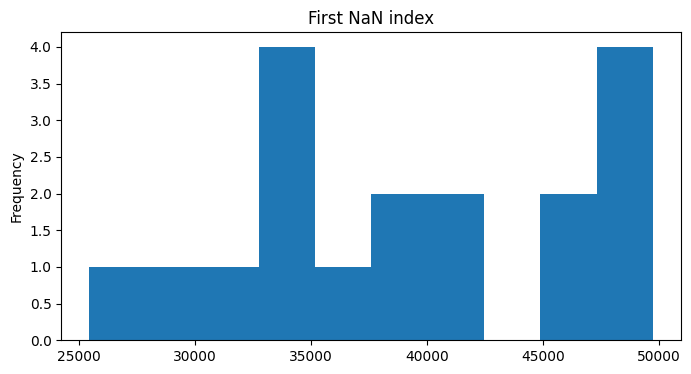

In [622]:
nan_count = np.isnan(df_data["lambdahat"]).value_counts()
print(nan_count)
if True in nan_count.index:
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    df_data["first_nan_index"].plot(kind="hist", ax=ax)
    ax.set_title("First NaN index");

In [623]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=df_data["model_dim"], nbinsx=50))
fig.update_layout(
    title="Model Parameter Count"
)

## $\lambda$ vs $\hat{\lambda}$

In [630]:
df = df_data
# df = df[df["true_rank"] < 2]
# df = df[df["true_multiplicity"] > 1]

s = 8
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df["true_lambda"], 
    y=df["lambdahat"], 
    mode='markers', 
    marker=dict(size=s),
    name='lambdahat'
))

fig.add_trace(go.Scatter(
    x=df["true_lambda"], 
    y=df["true_rank"], 
    mode='markers', 
    marker=dict(size=s),
    name='true_rank'
))

fig.add_trace(go.Scatter(
    x=df["true_lambda"], 
    y=df["model_dim"] / 2, 
    mode='markers', 
    marker=dict(size=s, color='green'),
    name='model dimension / 2'
))


fig.add_trace(go.Scatter(
    x=df["true_lambda"], 
    y=df["true_multiplicity"], 
    mode='markers', 
    marker=dict(size=s, color='purple'),
    name='multiplicity'
))

if "lambdahat_with_burnin" in df.columns:
    fig.add_trace(go.Scatter(
        x=df["true_lambda"], 
        y=df["lambdahat_with_burnin"], 
        mode='markers', 
        marker=dict(size=s),
        name='lambdahat_with_burnin'
    ))

if "lambdahat_extrapolated_multiitemp" in df.columns:
    fig.add_trace(go.Scatter(
        x=df["true_lambda"], 
        y=df["lambdahat_extrapolated_multiitemp"], 
        mode='markers', 
        marker=dict(size=s),
        name='lambdahat_extrapolated_multiitemp'
    ))


if "lambdahat_trained" in df.columns:
    fig.add_trace(go.Scatter(
        x=df["true_lambda"], 
        y=df["lambdahat_trained"], 
        mode='markers', 
        marker=dict(size=s),
        name='lambdahat_trained'
    ))

if "functional_rank" in df.columns:
    fig.add_trace(go.Scatter(
        x=df["true_lambda"], 
        y=df["functional_rank"] / 2, 
        mode='markers', 
        marker=dict(size=s),
        name='functional_rank / 2'
    ))


if "hessian_trace_estimate" in df.columns:
    fig.add_trace(go.Scatter(
        x=df["true_lambda"], 
        y=df["hessian_trace_estimate"], 
        mode='markers', 
        marker=dict(size=s),
        name='hessian_trace_estimate', 
        # yaxis="y2"
    ))

# Add the y=x line
sorted_true_lambda = sorted(df["true_lambda"])
fig.add_trace(go.Scatter(
    x=sorted_true_lambda, 
    y=sorted_true_lambda, 
    mode='lines', 
    line=dict(dash='dash', color='red', width=2),
    name='true_lambda'
))



fig.update_layout(
    title="Comparison of Metrics",
    xaxis_title="True lambda",
    yaxis_title="Metrics",
    legend_title="Legend",
    width=800,
    height=800, 
    yaxis=dict(
        title="Metric",
        side="left",
        showgrid=False,
        zeroline=False
    ),
    yaxis2=dict(
        title="Metric",
        side="right",
        overlaying="y",
        showgrid=False,
        zeroline=False
    )
)


# Save the figure as an image file
filepath = f'./outputs/images/{EXPT_NAME}_plot.html'
pio.write_html(fig, filepath)
# ! open $filepath
fig


In [618]:
df = df_data
s = 8
fig = go.Figure()


fig.add_trace(go.Scatter(
    x=df["true_lambda"], 
    y=df["lambdahat_with_burnin"], 
    mode='markers', 
    marker=dict(size=s),
    name='lambdahat_with_burnin'
))

# Add the y=x line
sorted_true_lambda = sorted(df["true_lambda"])
fig.add_trace(go.Scatter(
    x=sorted_true_lambda, 
    y=sorted_true_lambda, 
    mode='lines', 
    line=dict(dash='dash', color='red', width=2),
    name='true_lambda'
))


fig.update_layout(
    # title="Comparison of Metrics",
    margin=dict(l=40, r=10, t=10, b=40),
    xaxis_title="True Learning Coefficient",
    yaxis_title="Estimated Local Learning Coefficient",
    legend=dict(
        x=0.3,
        y=0.98,
        bordercolor="Black",
        borderwidth=1,
        bgcolor='rgba(255,255,255,0.9)',  # slightly transparent white background
        xanchor='right',
        yanchor='top'
    ),
    width=800,
    height=800, 
)



# Save the figure as an image file
config = sample_doc["config"]
truth_method = config["true_param_config"]["method"]
fileprefix = f"lambdahat_vs_lambda_{truth_method}_{EXPT_NAME}"
pio.write_html(fig, f'./outputs/images/{fileprefix}.html')
pio.write_image(fig, f"./outputs/images/{fileprefix}.png")
# ! open $filepath
fig


Text(0.5, 1.0, 'd=2676595-92022846')

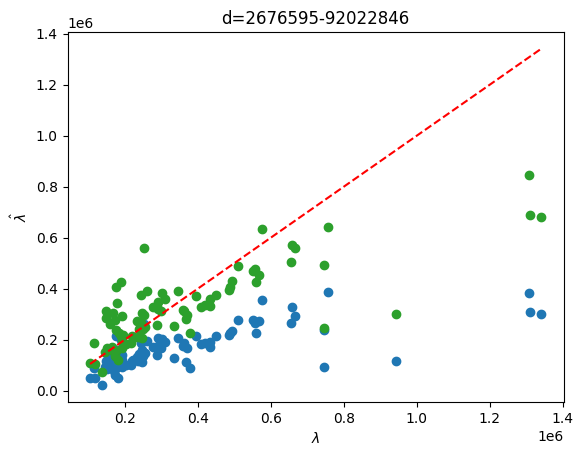

In [584]:
fig, ax = plt.subplots(1, 1)
ax.scatter(
    x=df["true_lambda"], 
    y=df["lambdahat"], 
)
ax.scatter(
    x=df["true_lambda"], 
    y=df["lambdahat_trained"], 
)

ax.scatter(
    x=df["true_lambda"], 
    y=df["lambdahat_with_burnin"], 
)
ax.plot(sorted_true_lambda, sorted_true_lambda, "r--")
ax.set_ylabel("$\hat{\lambda}$")
ax.set_xlabel("$\lambda$")
ax.set_title(f"d={df['model_dim'].min()}-{df['model_dim'].max()}")

In [611]:
df = df_data
fig = px.scatter(
    df, 
    x="true_lambda", 
    y="lambdahat", 
    # color="functional_rank",
    # color="true_multiplicity",
    # color="avg_width",
    color="model_dim",
    # color="num_layers",
    size="num_layers",
    # size="true_rank",
    labels={
        "true_lambda": "True lambda",
        "lambdahat": "lambdahat",
        "model_dim": "Model Dimension",
        "num_layers": "Number of Layers",
        "true_rank": "True Rank"
    },
    title="Scatter Plot of True Lambda vs Lambdahat"
)

# Add the y=x line
sorted_true_lambda = sorted(df["true_lambda"])
fig.add_trace(
    px.line(
        x=sorted_true_lambda, 
        y=sorted_true_lambda
    ).data[0]
)

# Update the layout
fig.update_layout(
    xaxis_title="True lambda",
    yaxis_title="Lambdahat",
    legend_title="Legend",
    width=800,
    height=800
)


## Loss trace

In [631]:
sample_loss_trace = sample_doc["info"]["loss_trace"]
# sample_loss_trace = df_data.iloc[10]["loss_trace"]
# distances = sample_doc["info"]["sgld_distances"]
nsamples = len(sample_loss_trace)

fig = go.Figure()

# Add trace for loss_trace
fig.add_trace(
    go.Scatter(
        x=list(range(nsamples)),
        y=sample_loss_trace,
        name="Loss Trace",
        yaxis="y1"
    )
)

# Add trace for distances
# fig.add_trace(
#     go.Scatter(
#         x=list(range(nsamples)),
#         y=distances,
#         name="Distances",
#         yaxis="y2"
#     )
# )

# Set layout for the graph
fig.update_layout(
    title="Loss Trace and Distances",
    xaxis_title="Sample Index",
    yaxis=dict(
        title="Loss Trace",
        side="left",
        showgrid=False,
        zeroline=False
    ),
    yaxis2=dict(
        title="Distances",
        side="right",
        overlaying="y",
        showgrid=False,
        zeroline=False
    )
)



## Effects of `sgld_config.num_steps`

In [596]:
s = 500
burn_in = 40000
sgld_num_steps = sample_doc["config"]["sgld_config"]["num_steps"]
n = sample_doc["config"]["num_training_data"]
data = []

# df = df_data[~np.isnan(df_data["lambdahat"])]
df = df_data

for i, row in df.iterrows():
    expt_id = row["_id"]
    trace = row["loss_trace"]
    init_loss = row["init_loss"]
    true_lambda = row["true_lambda"]
    for nstep in range(s + burn_in, sgld_num_steps + 1, s):
        nstep_lambdhat = (np.mean(trace[burn_in:nstep]) - init_loss) * n / np.log(n)
        data.append([expt_id, nstep, nstep_lambdhat, true_lambda])
df = pd.DataFrame(data, columns=["_id", "nstep", "lambdahat", "true_lambda"])

fig = px.scatter(
    df, 
    x="true_lambda", 
    y="lambdahat", 
    color="nstep",
    labels={
        "true_lambda": "True lambda",
        "lambdahat": "lambdahat",
        "nstep": "Num SGLD step"
    },
    title="True Lambda vs Lambdahat"
)

# Add the y=x line
sorted_true_lambda = sorted(df["true_lambda"])
fig.add_trace(
    px.line(
        x=sorted_true_lambda, 
        y=sorted_true_lambda
    ).data[0]
)

# Update the layout
fig.update_layout(
    xaxis_title="True lambda",
    yaxis_title="Lambdahat",
    legend_title="Legend",
    width=800,
    height=800, 
    # yaxis_type="log", 
    # xaxis_type="log",
)


## Functional rank

In [237]:
df = df_data
# df = df[df["functional_rank"] / 2 > df["true_lambda"]]
row = df.iloc[0]
svdvals = row["svdvals"]
threshold = 0.005

print(np.sum(np.array(svdvals) > threshold) / 2, row["functional_rank"] / 2, row["true_lambda"])

fig = px.histogram(x=np.log10(svdvals), nbins=100)
fig.add_vline(x=np.log10(threshold))


TypeError: '>' not supported between instances of 'NoneType' and 'float'

# MALA acceptance

In [610]:
df = df_data
probs = np.array(df.iloc[13]["mala_acceptance_probs"])
print(np.mean(probs[:, 1]))
fig = go.Figure()
fig.add_trace(
    px.line(
        x=probs[:, 0], 
        y=probs[:, 1]
    ).data[0]
)


0.9032926684341394


# MISC

In [561]:
from scipy.special import logsumexp
from scipy.stats import linregress

def stable_weighted_average(Ls, n, delta_beta, factor=None):
    """
    Compute: 1/m \sum_{j = 1}^m n Ls[j] exp(- delta_beta * n * Ls[j])
    """
    m = len(Ls)
    Ls = np.array(Ls)
    log_terms = - delta_beta * n * Ls
    if factor is not None:
        log_terms += np.log(factor)
    average = np.exp(logsumexp(log_terms) - np.log(m))
    return average

def extrapolated_wbic(losses, n, itemp1, itemp2):
    delta_beta = itemp2 - itemp1
    numerator = stable_weighted_average(losses, n, delta_beta, factor=n * losses)
    normalisation = stable_weighted_average(losses, n, delta_beta)
    return numerator / normalisation
    
def extrapolated_multiitemp_lambdahat(losses, n, itemp_og, num_extrapolation=5, return_full=False):
    itemps = linspaced_itemps_by_n(n, num_extrapolation)
    wbics = [
        extrapolated_wbic(losses, n, itemp_og, itemp_new) for itemp_new in itemps
    ]
    result = linregress(1 / itemps, wbics)
    if return_full: 
        return result
    else:
        return result.slope


def linspaced_itemps_by_n(n, num_itemps):
    """
    Returns a 1D numpy array of length `num_itemps` that contains `num_itemps`
    evenly spaced inverse temperatures between the values calculated from the
    formula 1/log(n) * (1 - 1/sqrt(2log(n))) and 1/log(n) * (1 + 1/sqrt(2ln(n))).
    The formula is used in the context of simulating the behavior of a physical
    system at different temperatures using the Metropolis-Hastings algorithm.
    """
    return np.linspace(
        1 / np.log(n) * (1 - 1 / np.sqrt(2 * np.log(n))),
        1 / np.log(n) * (1 + 1 / np.sqrt(2 * np.log(n))),
        num_itemps,
    )

losses = np.array(sample_doc["info"]["loss_trace"])
n = sample_doc["config"]["num_training_data"]
itemp = sample_doc["config"]["itemp"]
itemp2 = 1.5 / np.log(n)
print(sample_doc["info"]["lambdahat"])
print(sample_doc["info"]["true_lambda"])
extrapolated_multiitemp_lambdahat(losses, n, itemp)

2.3827648162841797
17.5


5.749342293074781

LinregressResult(slope=3.542918809698694, intercept=7.219362117757711, rvalue=0.9978700036787324, pvalue=8.98220540679529e-11, stderr=0.08188705995913216, intercept_stderr=0.7805204940326309)

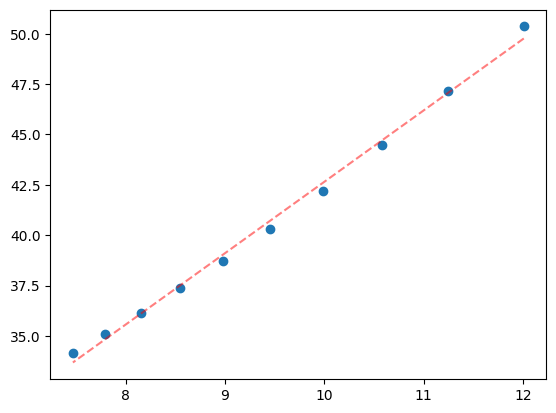

In [558]:
from scipy.stats import linregress

itemps = linspaced_itemps_by_n(n, 10)
losses = np.array(sample_doc["info"]["loss_trace"])[5000:]
n = sample_doc["config"]["num_training_data"]
itemp = sample_doc["config"]["itemp"]
wbics = [
    extrapolated_wbic(losses, n, itemp, itemp_new) for itemp_new in itemps
]
result = linregress(1/ itemps, wbics)

fig, ax = plt.subplots()
ax.scatter(1 / itemps, wbics)
ax.plot(1 / itemps, result.slope / itemps + result.intercept, "r--", alpha=0.5)
result

In [552]:
x = [1500, 1532, 2121, 1111, 1529, 1113, 1372, 1071, 1049, 2640, 2773, 2818, 2984, 1561, 2671, 2369]
sum([x[i -1] * x[i] for i in range(1, len(x))])

56892586

In [524]:
27 * n / np.log(n)

29314.877528469497